# 1D ballistic motion physics-informed neural network (PINN)

Based on [this](https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/). 

## Problem overview

Predicting the free-fall trajectory of an object given n observations of its vertical position $h$ and velocity $v$.
Exact solution is 

$$
h(t) = v(0)t - \textstyle\frac12 gt^2
$$
$$
v(t) = v(0) - gt
$$

But we dont want to "tell" the NN the governing equation, as in many case we won't have one. Instead we impose more 
general physical constraint(s)

In this case we use the principle of conservation of energy, which for this system can be expressed by:

$$
\frac{d}{dt}\Big(\textstyle\frac12mv^2(t) + mgh(t)\Big) = 0
$$

...which implies $\frac{dv}{dt} = -g$, but we won't tell the NN this.


## Environment set up

Create and activate a virtualenv, then

```
pip install -r requirements.txt
```


In [1]:
from pathlib import Path
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
def save_gif(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(
        fp=outfile,
        format="GIF",
        append_images=imgs[1:],
        save_all=True,
        duration=int(1000 / fps),
        loop=loop,
    )


def solution(g, v0, t):
    h = v0 * t + 0.5 * g * t**2
    v = v0 + g * t
    return torch.stack((h, v), -1)

In [3]:
class FCN(nn.Module):
    "Defines a connected network"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(
            *[
                nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()])
                for _ in range(N_LAYERS - 1)
            ]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Generate training data

First, we generate some training data from a small part of the true analytical solution.


torch.Size([5, 1]) torch.Size([5, 2])


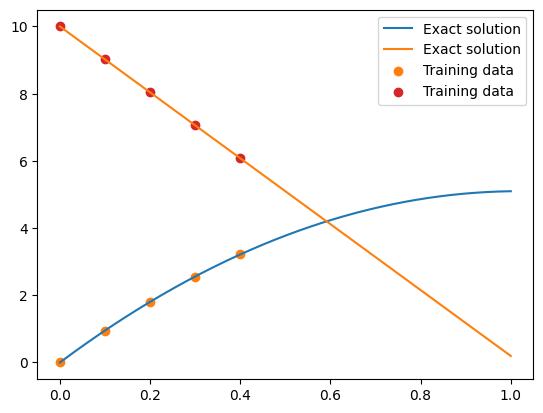

In [4]:
g = -9.80665
v0 = 10

# get the analytical solution over the full domain
t = torch.linspace(0, 1, 501).view(-1, 1)
hv = solution(g, v0, t).view(-1, 2)

# slice out a small number of points from the LHS of the domain
t_data = t[0:250:50]
hv_data = hv[0:250:50, :]
print(t_data.shape, hv_data.shape)

plt.figure()
plt.plot(t, hv, label="Exact solution")
plt.scatter(t_data, hv_data[:, 0], color="tab:orange", label="Training data")
plt.scatter(t_data, hv_data[:, 1], color="tab:red", label="Training data")
plt.legend()
plt.show()

## Normal neural network

> Next, we train a standard neural network (fully connected network) to fit these training points.

>We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

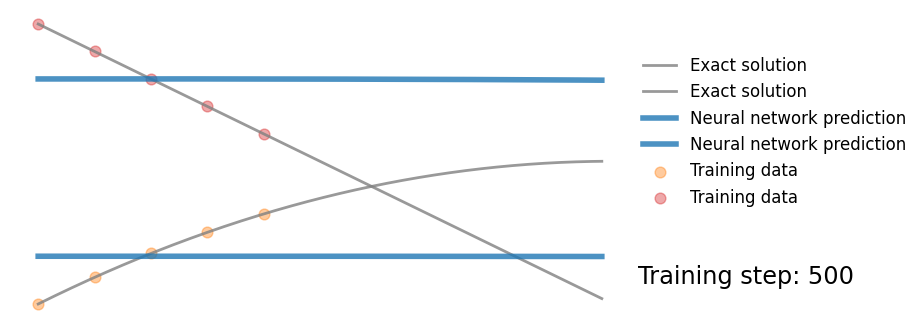

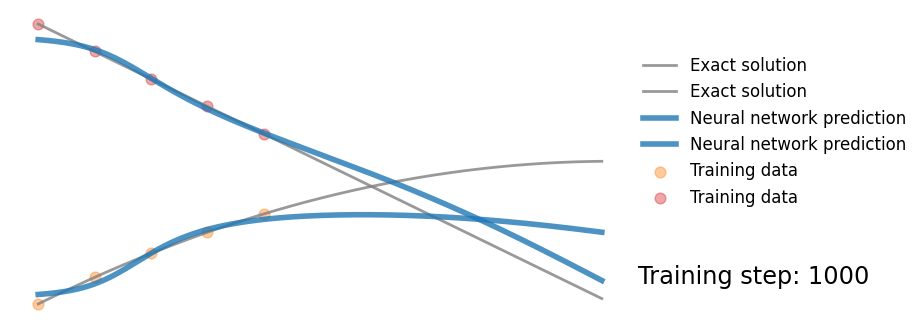

In [9]:
def plot_result(x, y, x_data, y_data, yh, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(
        x,
        yh,
        color="tab:blue",
        linewidth=4,
        alpha=0.8,
        label="Neural network prediction",
    )
    plt.scatter(
        x_data, y_data[:, 0], s=60, color="tab:orange", alpha=0.4, label="Training data"
    )
    plt.scatter(
        x_data, y_data[:, 1], s=60, color="tab:red", alpha=0.4, label="Training data"
    )
    if xp is not None:
        plt.scatter(
            xp,
            -0 * torch.ones_like(xp),
            s=60,
            color="tab:green",
            alpha=0.4,
            label="Physics loss training locations",
        )
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    # plt.xlim(-0.05, 1.05)
    # plt.ylim(-1.1, 1.1)
    plt.text(1.065, 0.7, "Training step: %i" % (i + 1), fontsize="xx-large", color="k")
    plt.axis("off")


Path("./plots").mkdir(exist_ok=True)

# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1, 2, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(1000):
    optimizer.zero_grad()
    hv_hat = model(t_data)
    loss = torch.mean((hv_hat - hv_data) ** 2)  # use mean squared error
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if (i + 1) % 10 == 0:
        hv_hat = model(t).detach()

        plot_result(t, hv, t_data, hv_data, hv_hat)

        file = "plots/nn_%.8i.png" % (i + 1)
        plt.savefig(
            file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white"
        )
        files.append(file)

        if (i + 1) % 500 == 0:
            plt.show()
        else:
            plt.close("all")

save_gif("nn.gif", files, fps=20, loop=0)

## PINN

The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.

Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

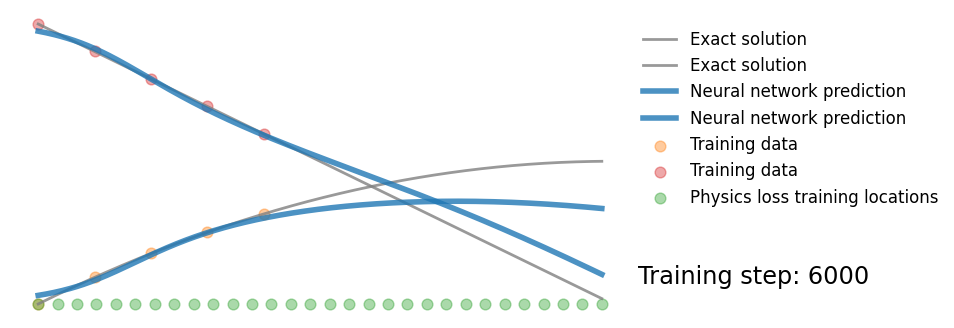

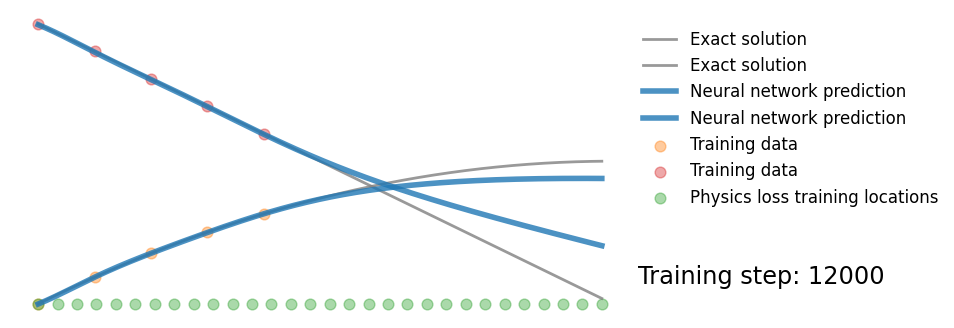

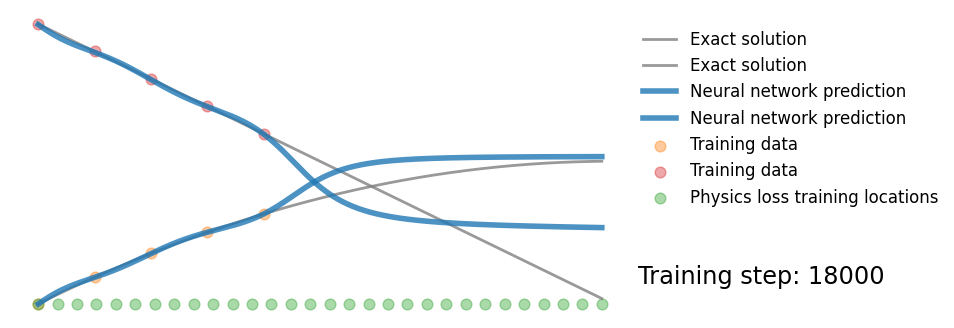

In [14]:
# sample locations over the problem domain
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
physics_weight = 1e-4

torch.manual_seed(123)
model = FCN(1, 2, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
files = []
for i in range(20000):
    optimizer.zero_grad()

    # compute the "data loss"
    hv_hat = model(t_data)
    data_loss = torch.mean((hv_hat - hv_data) ** 2)

    # compute the "physics loss"
    hv_p = model(t_physics)
    physics = g + hv_p[:, 0] + 0.5 * hv_p[:, 1] ** 2
    physics_loss = torch.mean(physics**2)

    # backpropagate joint loss
    loss = data_loss + physics_weight * physics_loss  # add two loss terms together
    loss.backward()
    optimizer.step()

    # plot the result as training progresses
    if (i + 1) % 150 == 0:
        hv_hat = model(t).detach()
        xp = t_physics.detach()

        plot_result(t, hv, t_data, hv_data, hv_hat, xp)

        file = "plots/pinn_%.8i.png" % (i + 1)
        plt.savefig(
            file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white"
        )
        files.append(file)

        if (i + 1) % 6000 == 0:
            plt.show()
        else:
            plt.close("all")

save_gif("pinn.gif", files, fps=20, loop=0)